In [1]:
import logging
logger = logging.getLogger('disp_xr')

# Configure basic logging
logger.setLevel(logging.INFO)  # Set logging level

# Create handler (console output)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)  # Set level for this handler

# Add handler to logger
logger.addHandler(handler)

# Prevent duplicate logs if the root logger already has handlers
logger.propagate = False

In [17]:
import disp_xr
from disp_xr import product, stack as disp_stack, utils, quality_metrics, io
from disp_xr.mintpy_utils.utils import find_reference_point 
from pyproj import Transformer
from pathlib import Path
import numpy as np

In [4]:
# Compare OPERA DISP v1.1 with PRODUCTION DISP v1.0
disp_df_prod = product.get_disp_info('/u/operapst/bato/work/CALVAL/disp-s1_official/v1.0/F08622/products')
disp_df_v11 = product.get_disp_info('/u/operapst/bato/work/CALVAL/disp-s1_official/v1.1/F08622/products')

Found OPERA DISP: 209 products
 Starting date: 2016-07-16 22:50:42
 Ending date: 2024-08-27 22:51:23
 Number of reference dates: 14
 Skip 0 duplicates
Found OPERA DISP: 239 products
 Starting date: 2016-07-16 22:50:42
 Ending date: 2024-12-13 22:51:21
 Number of reference dates: 16
 Skip 0 duplicates


In [5]:
%%time
stack_prod = disp_stack.combine_disp_product(disp_df_prod)

Stacking into common stack
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
Total elapsed time for disp_xr.stack.combine_disp_product: 0.41 minutes (24.84 seconds)


CPU times: user 8.94 s, sys: 1.61 s, total: 10.6 s
Wall time: 24.8 s


In [6]:
%%time
stack_v11 = disp_stack.combine_disp_product(disp_df_v11)

Stacking into common stack
 Chunk blocks: {'time': -1, 'x': 512, 'y': 512}
Total elapsed time for disp_xr.stack.combine_disp_product: 1.62 minutes (97.01 seconds)


CPU times: user 13 s, sys: 1.58 s, total: 14.6 s
Wall time: 1min 37s


In [32]:
stack_v11

<xarray.Dataset> Size: 802GB
Dimensions:                         (time: 239, y: 7959, x: 9587)
Coordinates:
  * y                               (y) float64 64kB 4.637e+06 ... 4.399e+06
  * x                               (x) float64 77kB 4.641e+05 ... 7.516e+05
  * time                            (time) datetime64[ns] 2kB 2016-09-26T22:5...
Data variables: (12/13)
    spatial_ref                     (time) int64 2kB 0 0 0 0 0 0 ... 0 0 0 0 0 0
    reference_time                  (time) datetime64[ns] 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    displacement                    (y, x, time) float32 73GB dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
    short_wavelength_displacement   (y, x, time) float32 73GB dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
    recommended_mask                (y, x, time) float32 73GB dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
    connected_component_labels      (y, x, time) float32 73GB dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
    ...                              ...
    estimated_phase_quality         (y, x, time) float32 73GB dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
    persistent_scatterer_mask       (y, x, time) float32 73GB dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
    shp_counts                      (y, x, time) float32 73GB dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
    water_mask                      (y, x, time) float32 73GB dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
    phase_similarity                (y, x, time) float32 73GB dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
    timeseries_inversion_residuals  (y, x, time) float32 73GB dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D-108765
    title:               OPERA_L3_DISP-S1 Product

In [ ]:
flag = np.bool_([dd in v11_dates.date12 for dd in prod_dates.date12])
common_dates = np.array(prod_dates.date12)[flag]

In [21]:
common_dates = np.array(stack_prod.time[stack_prod.time.isin(stack_v11.time)])
start_date = np.min(common_dates)
end_date = np.max(common_dates)

In [26]:
disp_df_prod.start_date.min(), disp_df_v11.start_date.min() # have the same first reference date

(Timestamp('2016-07-16 22:50:42'), Timestamp('2016-07-16 22:50:42'))

In [ ]:
reference_xy = (np.float64(-73.97908275641281), np.float64(40.703502549850235))

In [78]:
import pyproj
epsg = pyproj.CRS(stack_prod.spatial_ref.attrs['crs_wkt']).to_epsg()
transformer = pyproj.Transformer.from_crs("epsg:4326", f"epsg:{epsg}", always_xy=True)
x, y = transformer.transform(*reference_xy)

In [79]:
y,x

(4506344.999952296, 586244.9999998048)

In [80]:
%%time
# Get cumulative displacement
cum_disp_prod = stack_prod.sel(time=end_date).displacement.values
cum_disp_prod_mask = stack_prod.sel(time=end_date).recommended_mask.values

CPU times: user 34.6 s, sys: 2.81 s, total: 37.4 s
Wall time: 31.6 s


In [83]:
ref_data_prod = stack_prod.sel(time=end_date, y=y, x=x, method='nearest').displacement.values

In [48]:
%%time
# Get cumulative displacement
cum_disp_v11 = stack_v11.sel(time=end_date).displacement.values
cum_disp_v11_mask = stack_v11.sel(time=end_date).recommended_mask.values

CPU times: user 37.4 s, sys: 3.03 s, total: 40.5 s
Wall time: 34.7 s


In [196]:
def _get_extent(ds):
    transform = ds.spatial_ref.attrs['GeoTransform'].split(' ')
    x0, dx, _, y0, _, dy = map(float, transform)
    x1 = x0 + dx * ds.sizes['x']
    y1 = y0 + dy * ds.sizes['y']
    return (x0, x1, y1, y0)

import warnings
def add_colorbar(fig, loc, im, labelsize=4, label='mm/yr', **kwargs):
    warnings.simplefilter("ignore")
    cb_kwargs = dict(orientation='horizontal', extend='neither')
    cbar_ax = fig.add_axes(loc)
    cb = fig.colorbar(im, cax=cbar_ax, **{**cb_kwargs, **kwargs})
    tick_locator = matplotlib.ticker.MaxNLocator(nbins=3)
    cb.locator = tick_locator
    cb.set_ticklabels(cb.get_ticks(), fontsize=labelsize)
    if label: cb.set_label(label, size=labelsize)
    cb.ax.tick_params(axis="both", grid_color='white',
                       which='major', labelsize=labelsize, length=2)
    cb.outline.set_edgecolor('black')
    cb.outline.set_linewidth(0.5)
    cb.update_ticks()
    return cb

In [85]:
ref_data_v11 = stack_v11.sel(time=end_date, y=y, x=x, method='nearest').displacement.values

Text(0.5, 1.0, 'Difference. [cm]')

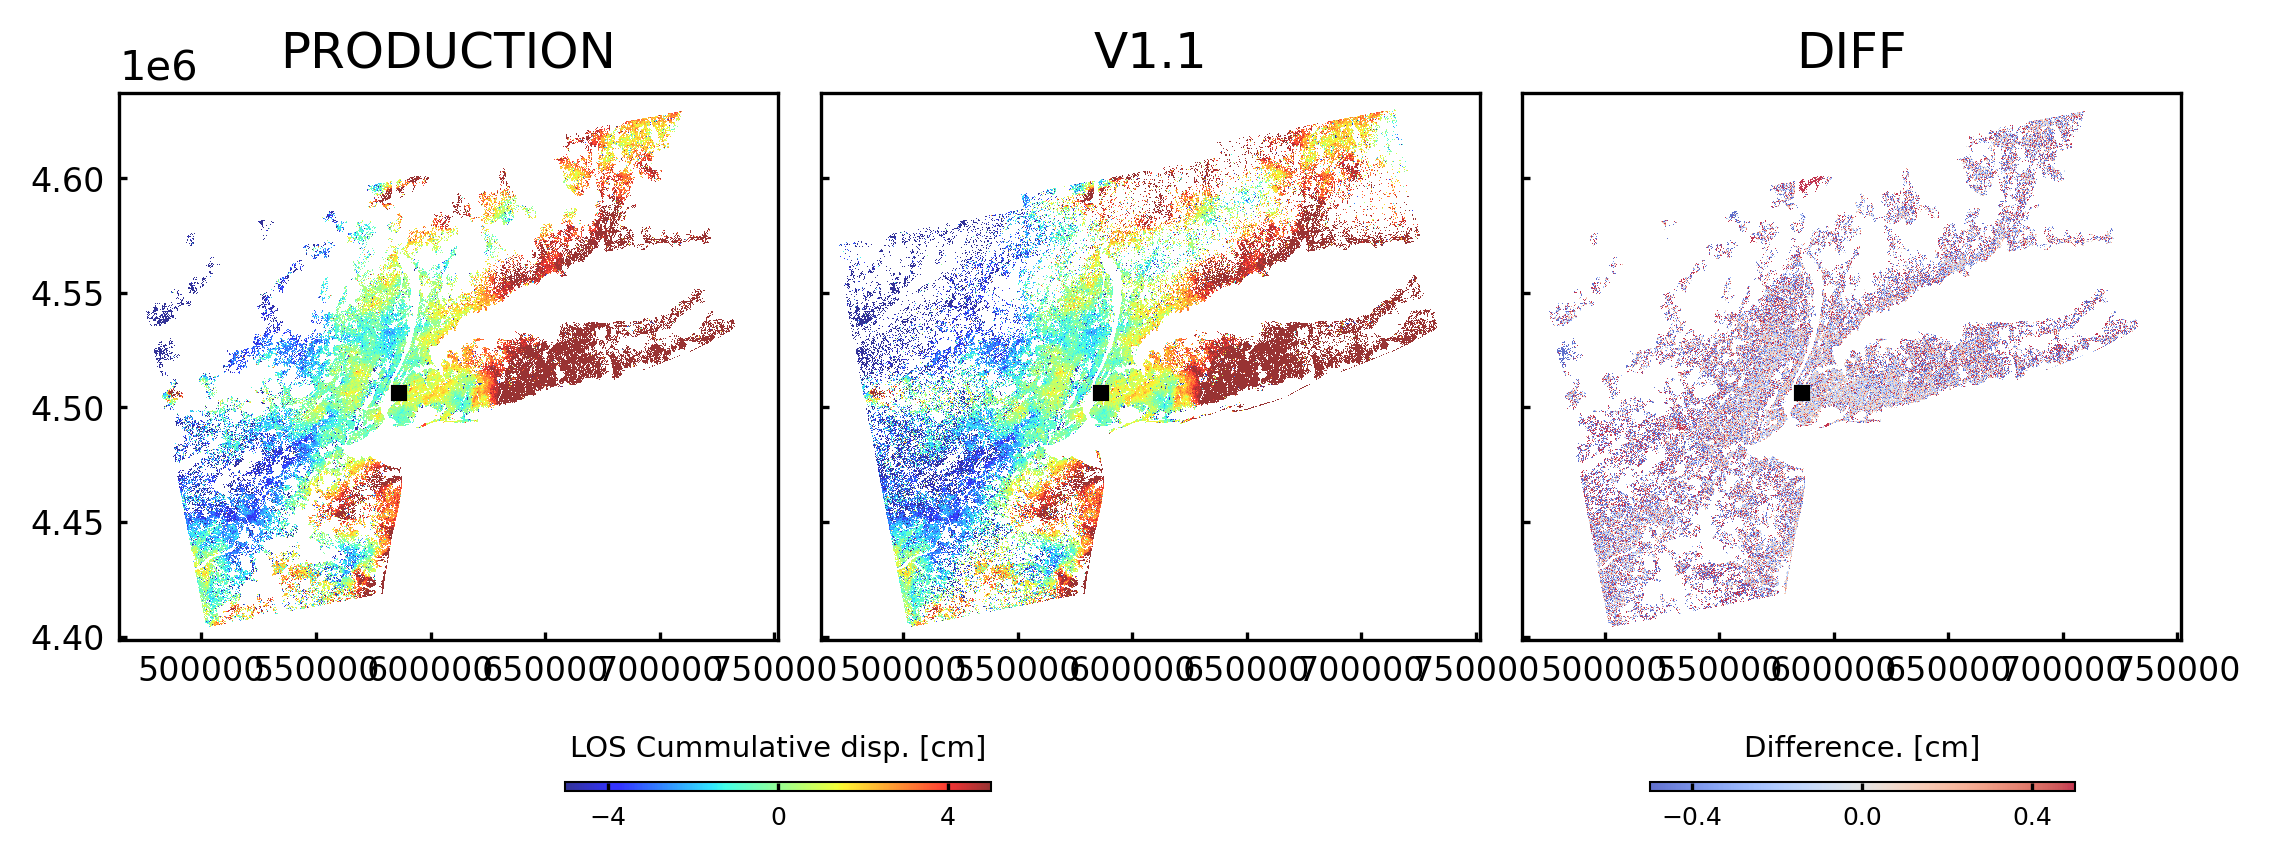

In [197]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
labels = ['PRODUCTION', 'v1.1', 'DIFF']
subplots_positions = {labels[0]: [0.02, 0.1, 0.31, 0.8],
                        labels[1]: [0.35, 0.1, 0.31, 0.8],
                        labels[2]: [0.68, 0.1, 0.31, 0.8]}

# Get figure layout
cm = 1/2.54 # width X height
fig = plt.figure(figsize=(18*cm, 8*cm), layout="none", dpi=300)
spec = GridSpec(ncols=2, nrows=1, figure=fig)
axs =  {}
for p in subplots_positions.keys(): axs[p] = fig.add_subplot(spec[0,0])
for fig_label in axs: axs[fig_label].set_position(subplots_positions[fig_label])

# Set-up 
label_kwargs =dict(direction="in", length=2, labelsize=8)
for label in labels:
    if label in labels[1:]:
        axs[label].tick_params(labelleft=False,
                            **label_kwargs)
    else:
        axs[label].tick_params(**label_kwargs)

# Default plot kwargs
plot_kwargs = dict(interpolation='nearest', cmap='jet',
                clim=[-5, 5], zorder=1, alpha=0.8)

# Plot
im = {}
prod_data = np.ma.masked_array((cum_disp_prod-ref_data_prod)*1e2,
                               mask=~np.bool_(cum_disp_mask))
v11_data = np.ma.masked_array((cum_disp_v11-ref_data_v11)*1e2,
                              mask=~np.bool_(cum_disp_v11_mask))

im[labels[0]] = axs[labels[0]].imshow(prod_data, extent=_get_extent(stack_prod), **plot_kwargs) # to cm
im[labels[1]] = axs[labels[1]].imshow(v11_data, extent=_get_extent(stack_v11), **plot_kwargs) # to cm

# Difference
difference =  prod_data - v11_data
vmin = np.nanmean(difference) - np.nanstd(difference)
vmax = np.nanmean(difference) + np.nanstd(difference)
divnorm = matplotlib.colors.TwoSlopeNorm(vmin=-0.5,
                                            vcenter=0.,
                                            vmax=0.5)
diff_kwargs = dict(cmap='coolwarm', norm=divnorm, clim=[-0.5, 0.5])
plot_kwargs = {**plot_kwargs, **diff_kwargs}

im[labels[2]] = axs[labels[2]].imshow(difference, extent=_get_extent(stack_prod), **plot_kwargs) # to cm 

# Plot reference
for label in labels:
    # Plot ref
    axs[label].plot(x, y, 'ks', ms=3)
    
    # Set extent
    axs[label].set_title(label.upper())


unit = 'cm'
# add colorbar
cb = add_colorbar(fig, [0.33-0.1, 0.05, 0.2, 0.01], im[labels[1]], label='', labelsize=6)
cb.ax.tick_params(direction="in", length=2)
cb.ax.set_title(f'LOS Cummulative disp. [{unit}]', fontsize=7)

# add difference colorbar
cb = add_colorbar(fig, [0.84-0.1, 0.05, 0.2, 0.01], im[labels[2]], label='', labelsize=6)
cb.ax.tick_params(direction="in", length=2)
cb.ax.set_title(f'Difference. [{unit}]', fontsize=7)

In [200]:
ts_point_utm

[(595206.0745226223, 4514047.334405817),
 (584651.0364822878, 4508790.808113095),
 (592700.5552713361, 4511335.386712742),
 (591236.4754025463, 4507968.727221809)]

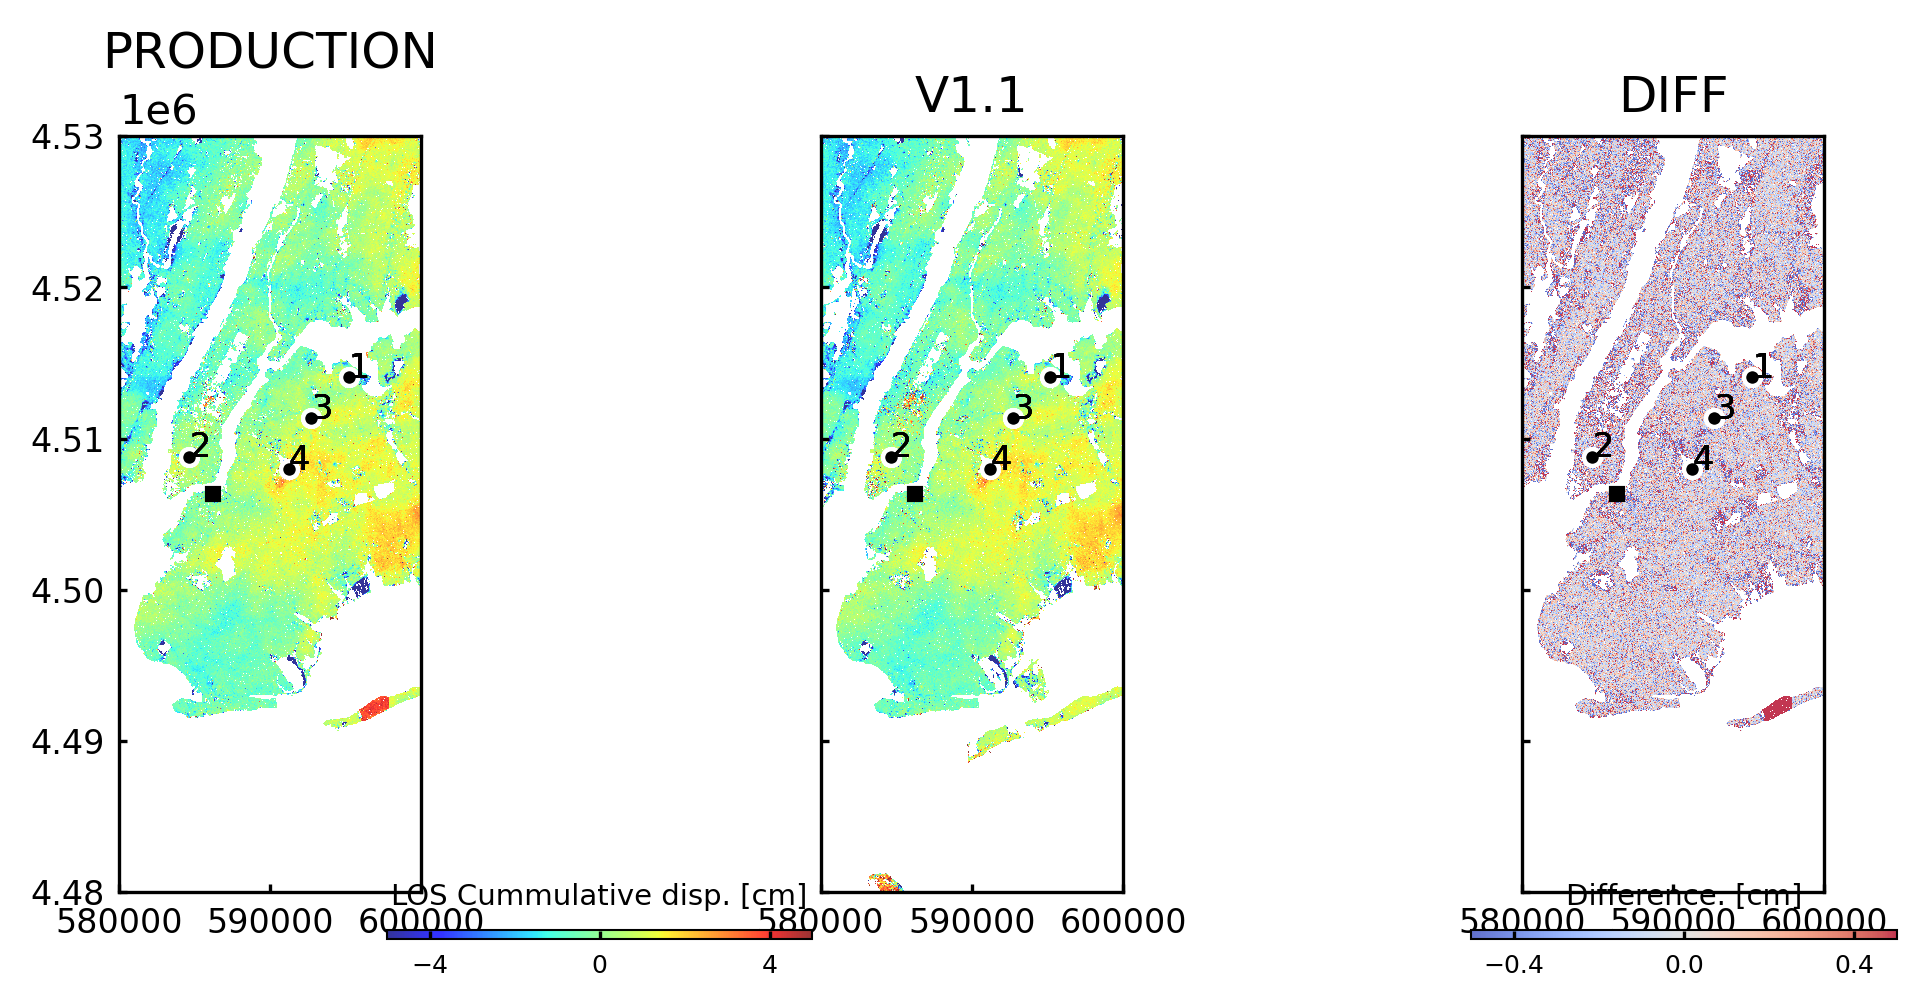

In [203]:
for ix, pp in enumerate(ts_point_utm):
    for ax in axs.values(): 
        ax.plot(*pp, 'ko', markeredgecolor='white', ms=4)
        ax.annotate(ix+1,(pp[0],pp[1]), fontsize=8)
        ax.set_ylim(4.48e6, 4.53e6)
        ax.set_xlim(5.8e5, 6e5)
display(fig)

In [186]:
np.nanmin(difference), np.nanmax(difference)

(np.float32(-22.899454), np.float32(36.462357))

# TIMESERIES

In [136]:
import pandas as pd
from scipy import stats

def _rmse(predictions, targets):
    return np.sqrt(np.nanmean((np.ma.masked_invalid(predictions) - np.ma.masked_invalid(targets)) ** 2))

def _plot_subplots(fig, subplot_pos):
    spec = GridSpec(ncols=2, nrows=1, figure=fig)
    ax =  {}
    for p in subplot_pos.keys(): ax[p] = fig.add_subplot(spec[0,0])
    for fig_label in ax: ax[fig_label].set_position(subplot_pos[fig_label])
    return fig, ax

def plot_scatterplot(ax,
                     data1_ts, data2_ts,
                     label1, label2,
                     scale=1e2, fontsize=6, 
                     unit='cm', **kwargs):
    
    # Convert to pandas
    data1_df = pd.DataFrame(data1_ts).T
    data1_df = data1_df.rename(columns={0:'date1', 1:'disp1'})

    data2_df = pd.DataFrame(data2_ts).T
    data2_df = data2_df.rename(columns={0:'date2', 1:'disp2'})

    # Merge, and keep common dates
    merged_df = pd.merge(data1_df, data2_df,
                         left_on='date1', right_on='date2',
                         how='inner')

    # Get min, and max
    df_min = np.round(np.min(merged_df[['disp1', 'disp2']].min()), 2)
    df_max = np.round(np.max(merged_df[['disp1', 'disp2']].max()), 2)
    ax_range = np.max(np.abs([df_min, df_max]))
    ax_range += ax_range*0.2 # increase by 20%
    ax_lims = [-ax_range*scale, ax_range*scale]

    # text upper corner
    txt_xy = ax_range- ax_range*0.1
    txt_xy *= scale

    yrange = (ax_range*2) * scale
    r = yrange/20

    # Replace pandas nat with nan
    merged_df['disp1'] = merged_df['disp1'].replace({pd.NaT: np.nan})
    merged_df['disp2'] = merged_df['disp2'].replace({pd.NaT: np.nan})

    # Plot
    ax.plot(merged_df.disp1*scale, merged_df.disp2*scale, 'o', **kwargs)
    
    ax.plot(ax_lims, ax_lims, lw=0.5, color='navy')
    ax.set_ylabel(f'{label1} [{unit}]', fontsize=fontsize, labelpad=-0.1)
    ax.set_xlabel(f'{label2} [{unit}]', fontsize=fontsize, labelpad=-0.1)
    ax.set_xlim(ax_lims)
    ax.set_ylim(ax_lims)

    # Get stats
    merged_df = merged_df.dropna()
    rmse = _rmse(merged_df.disp1.values, merged_df.disp2.values)
    mad = stats.median_abs_deviation(merged_df.disp1 - merged_df.disp2)
    r2 = stats.pearsonr(np.float64(merged_df.disp1), np.float64(merged_df.disp2))[0]


    ax.text(-txt_xy, txt_xy, f'R2: {r2:.2f}', weight='bold', fontsize=fontsize-1)
    ax.text(-txt_xy, txt_xy-r, f'RMSE: {rmse*scale:.2f} {unit}', weight='bold', fontsize=fontsize-1)
    ax.text(-txt_xy, txt_xy-r*2, f'MAD: {mad*scale:.2f} {unit}', weight='bold', fontsize=fontsize-1)
    ax.tick_params(direction='in', labelsize=fontsize, length=2)
    return merged_df

def plot_histogram(ax, difference, bins=20, scale=1e2, unit='cm', fontsize=6):
    # histogram of differences
    ax.hist(difference*scale, bins=bins, color='red', alpha=0.5)
    ax.set_xlabel(f'Diff. [{unit}]', fontsize=fontsize, labelpad=-0.2)
    ax.tick_params(direction='in', labelsize=fontsize, length=2, pad=1.5)
    ax.axvline(difference.mean()*scale, color='darkred', linestyle='--', label='Mean')
    return ax

In [114]:
# Select point for ts comparison
ts_points = [[-73.871854,  40.771890],
             [-73.997618, 40.725698],
             [-73.90194, 40.74775],
             [-73.91977, 40.71759]]

In [115]:
ts_point_utm = [transformer.transform(*p) for p in ts_points]
ts_point_utm

[(595206.0745226223, 4514047.334405817),
 (584651.0364822878, 4508790.808113095),
 (592700.5552713361, 4511335.386712742),
 (591236.4754025463, 4507968.727221809)]

In [119]:
%%time
prod_ts = stack_prod.sel(x=ts_point_utm[0][0], y=ts_point_utm[0][1], method='nearest').displacement.values
prod_ts_mask = stack_prod.sel(x=ts_point_utm[0][0], y=ts_point_utm[0][1], method='nearest').recommended_mask.values
reference_ts = stack_prod.sel(y=y, x=x, method='nearest').displacement.values

In [120]:
%%time
v11_ts = stack_v11.sel(x=ts_point_utm[0][0], y=ts_point_utm[0][1], method='nearest').displacement.values
v11_ts_mask = stack_v11.sel(x=ts_point_utm[0][0], y=ts_point_utm[0][1], method='nearest').recommended_mask.values
reference_ts_v11 = stack_v11.sel(y=y, x=x, method='nearest').displacement.values

CPU times: user 25.1 s, sys: 7.3 s, total: 32.4 s
Wall time: 2min 31s


In [ ]:
def _plot_timeseries(ts_path, point_lalo, 
                     labels=['opera', 'fringe'],
                     colors=['blue', 'green'],
                     ref_lalo=None, ref_date=None,
                     radius=35, fontsize=8,
                     scale=1e2, unit='cm'):

    subplots_positions = {'ts': [0.03, 0.22, 0.73, 0.76],
                          'sp': [0.83, 0.25, 0.16, 0.73],
                          'hist': [0.83, 0.01, 0.16, 0.15],
                          'ts_dif': [0.03, 0.02, 0.73, 0.17]}    

    # Get figure layout
    cm = 1/2.54 # width X height
    fig = plt.figure(figsize=(18*cm, 6*cm), layout="none", dpi=300)
    fig, ax = _plot_subplots(fig, subplots_positions) 

    ts_data = {}
    # Plot timeseries
    for label, color in zip(labels, colors):
        ts_data[label] = _get_timeseries(ts_path[label], point_lalo[1], point_lalo[0],
                                        ref_lalo=ref_lalo,
                                        radius=radius, ref_date=ref_date)
        
        ax['ts'].plot(ts_data[label][0],ts_data[label][1]*scale, '.',
                color=color, label=label.upper(), ms=3)
    
    ax['ts'].set_ylabel(f'Disp. [{unit}]', fontsize=fontsize)
    ax['ts'].legend(fontsize=fontsize)
    ax['ts'].set_title(f'Point at lat: {point_lalo[1]:.4f} , lon: {point_lalo[0]:.4f}, radius {radius:.3g} m',
                       fontsize=fontsize)
    ax['ts'].tick_params(labelsize=fontsize, labelbottom=False)
    ax['ts'].axhline(0, color='gray', lw=0.3, linestyle='--')
    ax['ts'].axvline(ptime.date_list2vector([ref_date])[0], color='gray', linestyle='--', lw=0.3)
    
    # Plot scatter plot
    df = plot_scatterplot(ax['sp'], ts_data[labels[0]], ts_data[labels[1]],
                          labels[0].upper(), labels[1].upper(),
                          ms=1, fontsize=fontsize-2,
                          scale=scale, unit=unit)
    
    # histogram of differences
    ax['hist'] = plot_histogram(ax['hist'], df.disp1-df.disp2, scale=scale, unit=unit, fontsize=fontsize-2)

    # Differences
    ax['ts_dif'].bar(df.date1, (df.disp1 - df.disp2)*scale, color='red', width=10, label=f'{labels[0].upper()}-{labels[1].upper()}')
    ax['ts_dif'].set_ylabel(f'Diff. [{unit}]', fontsize=fontsize)
    ax['ts_dif'].tick_params(labelsize=fontsize)
    ax['ts_dif'].set_xticks(ax['ts'].get_xticks())
    ax['ts_dif'].set_xlim(ax['ts'].get_xlim())
    ax['ts_dif'].axhline(0, color='r', lw=0.5, linestyle='--')
    ax['ts_dif'].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y/%m'))
    ax['ts_dif'].legend(fontsize=fontsize-2)
    return fig, ax

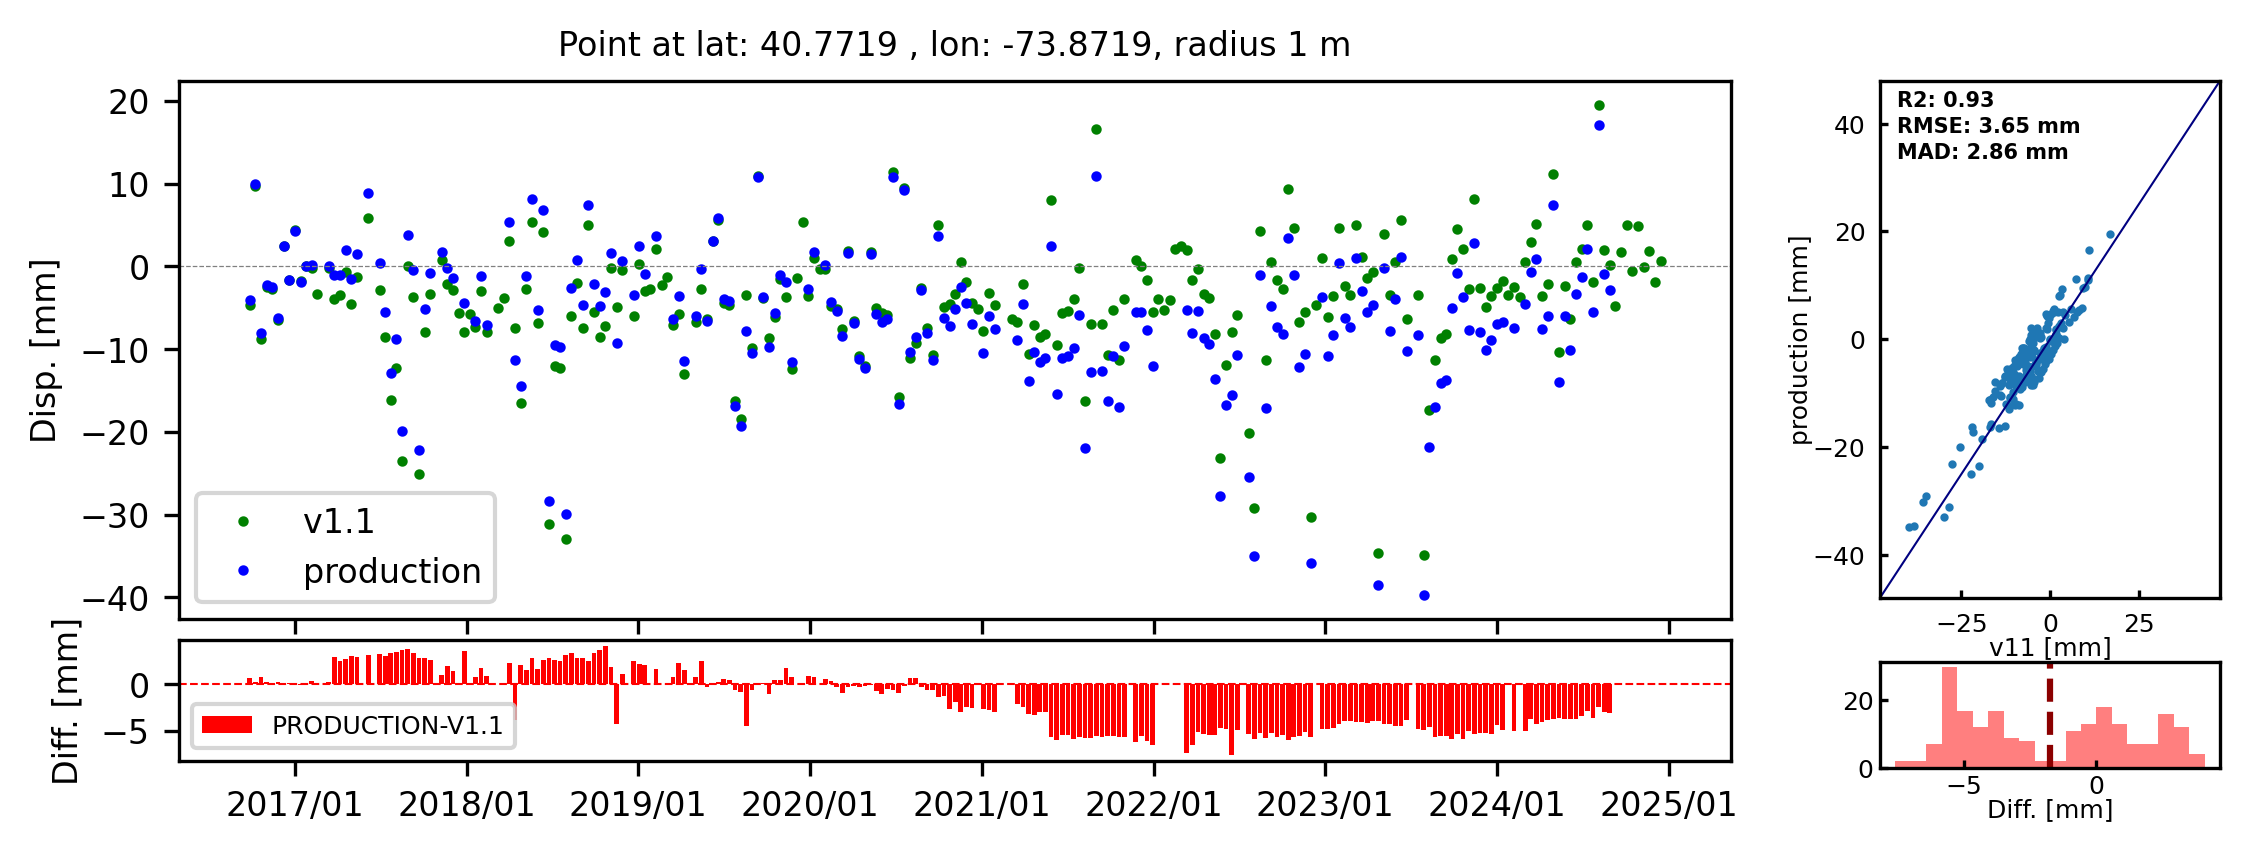

In [166]:
subplots_positions = {'ts': [0.03, 0.22, 0.73, 0.76],
                    'sp': [0.83, 0.25, 0.16, 0.73],
                    'hist': [0.83, 0.01, 0.16, 0.15],
                    'ts_dif': [0.03, 0.02, 0.73, 0.17]}    

point_lalo = ts_points[0]
fontsize = 8
radius = 1

# Get figure layout
cm = 1/2.54 # width X height
fig = plt.figure(figsize=(18*cm, 6*cm), layout="none", dpi=300)
fig, ax = _plot_subplots(fig, subplots_positions) 

ts_data = {}
# Plot timeseries
tv11 = stack_v11.time.values, np.ma.masked_array(v11_ts, mask=~np.bool_(v11_ts_mask)) - reference_ts_v11
tprod = stack_prod.time.values, np.ma.masked_array(prod_ts, mask=~np.bool_(prod_ts_mask)) - reference_ts

ax['ts'].plot(tv11[0],tv11[1]*1e3, '.',
        color='green', label='v1.1', ms=3)
ax['ts'].plot(tprod[0],tprod[1]*1e3, '.',
        color='blue', label='production', ms=3)
unit='mm'
ax['ts'].set_ylabel(f'Disp. [{unit}]', fontsize=fontsize)
ax['ts'].legend(fontsize=fontsize)
ax['ts'].set_title(f'Point at lat: {point_lalo[1]:.4f} , lon: {point_lalo[0]:.4f}, radius {radius:.3g} m',
                fontsize=fontsize)
ax['ts'].tick_params(labelsize=fontsize, labelbottom=False)
ax['ts'].axhline(0, color='gray', lw=0.3, linestyle='--')
#ax['ts'].axvline(stack.time([ref_date])[0], color='gray', linestyle='--', lw=0.3)

# Plot scatter plot
df = plot_scatterplot(ax['sp'], tprod, tv11,
                        'production', 'v11',
                        ms=1, fontsize=fontsize-2,
                        scale=1e3, unit='mm')

# histogram of differences
ax['hist'] = plot_histogram(ax['hist'], df.disp1-df.disp2, scale=1e3, unit='mm', fontsize=fontsize-2)

# Differences
unit='mm'
ax['ts_dif'].bar(df.date1, (df.disp1 - df.disp2)*1e3, color='red', width=1e1,label=f'{labels[0].upper()}-{labels[1].upper()}')
ax['ts_dif'].set_ylabel(f'Diff. [{unit}]', fontsize=fontsize)
ax['ts_dif'].tick_params(labelsize=fontsize)
ax['ts_dif'].set_xticks(ax['ts'].get_xticks())
ax['ts_dif'].set_xlim(ax['ts'].get_xlim())
ax['ts_dif'].axhline(0, color='r', lw=0.5, linestyle='--')
ax['ts_dif'].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y/%m'))
ax['ts_dif'].legend(fontsize=fontsize-2)

In [167]:
%%time
prod_ts = stack_prod.sel(x=ts_point_utm[1][0], y=ts_point_utm[1][1], method='nearest').displacement.values
prod_ts_mask = stack_prod.sel(x=ts_point_utm[1][0], y=ts_point_utm[1][1], method='nearest').recommended_mask.values
reference_ts = stack_prod.sel(y=y, x=x, method='nearest').displacement.values

CPU times: user 21.9 s, sys: 6.24 s, total: 28.2 s
Wall time: 52.8 s


In [168]:
%%time
v11_ts = stack_v11.sel(x=ts_point_utm[1][0], y=ts_point_utm[1][1], method='nearest').displacement.values
v11_ts_mask = stack_v11.sel(x=ts_point_utm[1][0], y=ts_point_utm[1][1], method='nearest').recommended_mask.values
reference_ts_v11 = stack_v11.sel(y=y, x=x, method='nearest').displacement.values

CPU times: user 25.2 s, sys: 7.36 s, total: 32.5 s
Wall time: 1min 19s


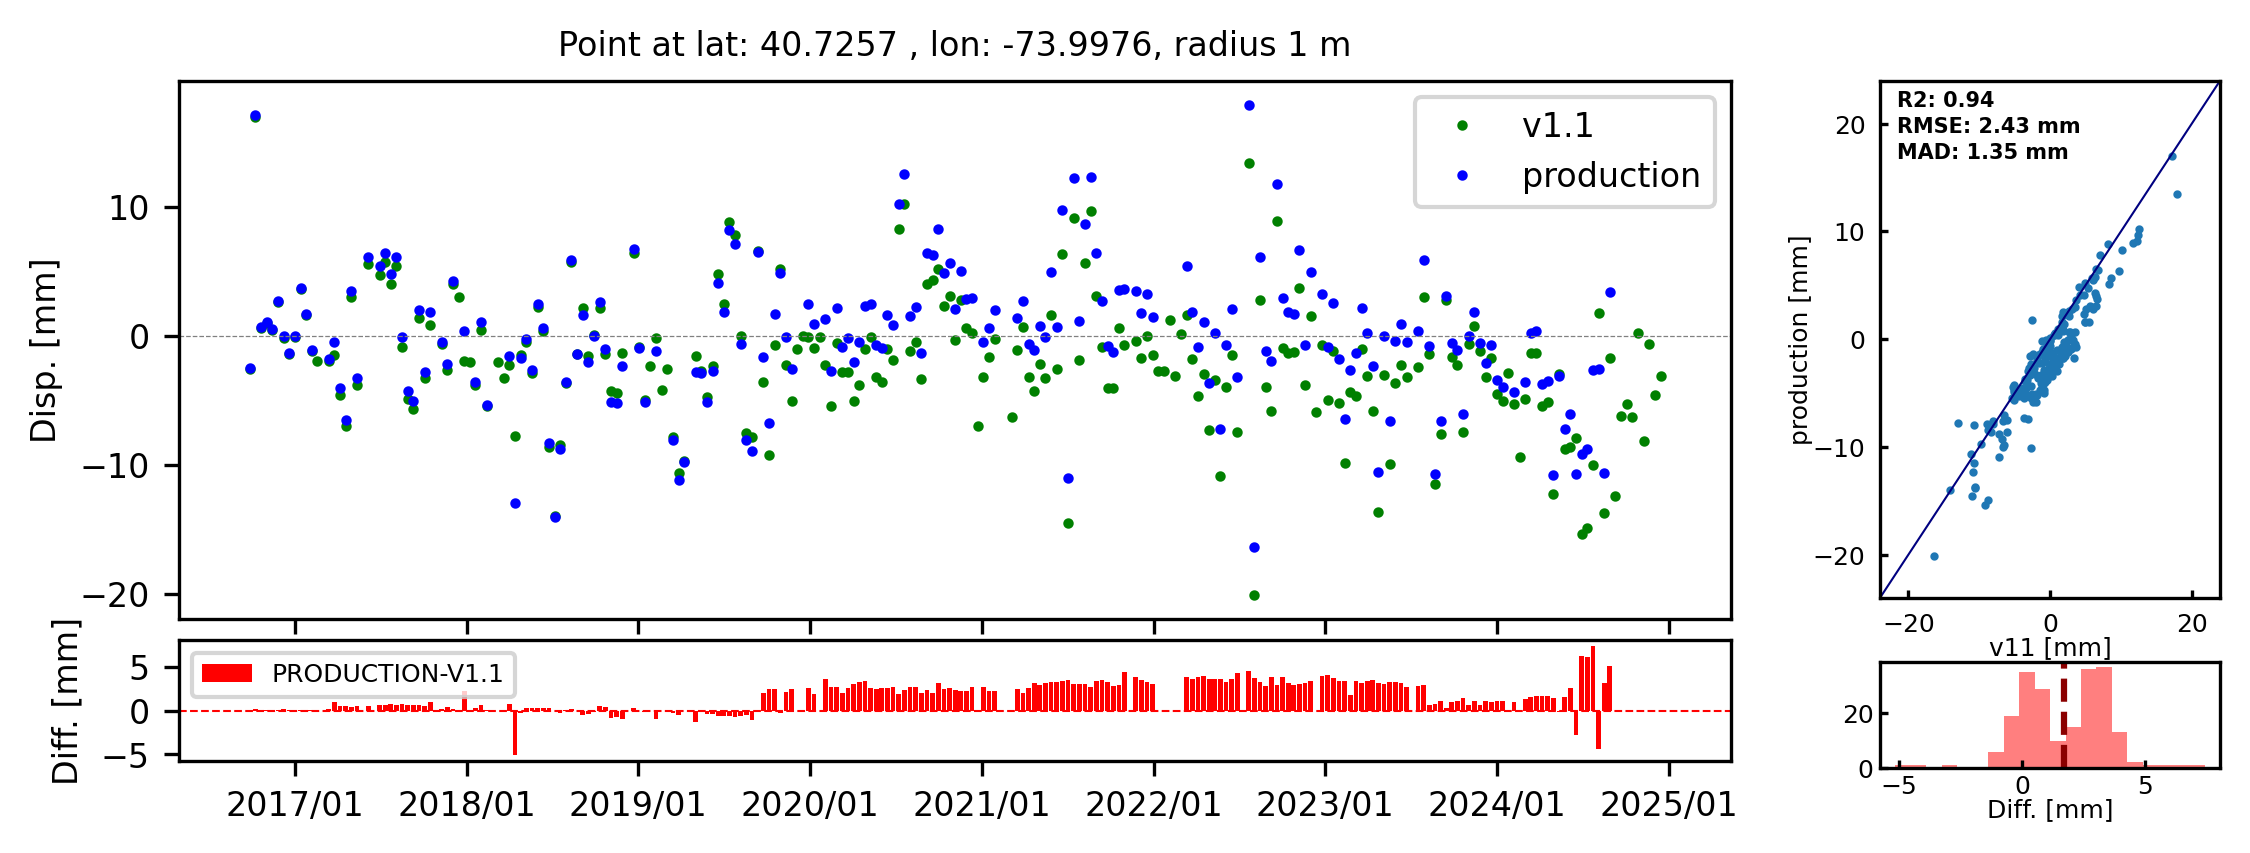

In [169]:
subplots_positions = {'ts': [0.03, 0.22, 0.73, 0.76],
                    'sp': [0.83, 0.25, 0.16, 0.73],
                    'hist': [0.83, 0.01, 0.16, 0.15],
                    'ts_dif': [0.03, 0.02, 0.73, 0.17]}    

point_lalo = ts_points[1]
fontsize = 8
radius = 1

# Get figure layout
cm = 1/2.54 # width X height
fig = plt.figure(figsize=(18*cm, 6*cm), layout="none", dpi=300)
fig, ax = _plot_subplots(fig, subplots_positions) 

ts_data = {}
# Plot timeseries
tv11 = stack_v11.time.values, np.ma.masked_array(v11_ts, mask=~np.bool_(v11_ts_mask)) - reference_ts_v11
tprod = stack_prod.time.values, np.ma.masked_array(prod_ts, mask=~np.bool_(prod_ts_mask)) - reference_ts

ax['ts'].plot(tv11[0],tv11[1]*1e3, '.',
        color='green', label='v1.1', ms=3)
ax['ts'].plot(tprod[0],tprod[1]*1e3, '.',
        color='blue', label='production', ms=3)
unit='mm'
ax['ts'].set_ylabel(f'Disp. [{unit}]', fontsize=fontsize)
ax['ts'].legend(fontsize=fontsize)
ax['ts'].set_title(f'Point at lat: {point_lalo[1]:.4f} , lon: {point_lalo[0]:.4f}, radius {radius:.3g} m',
                fontsize=fontsize)
ax['ts'].tick_params(labelsize=fontsize, labelbottom=False)
ax['ts'].axhline(0, color='gray', lw=0.3, linestyle='--')
#ax['ts'].axvline(stack.time([ref_date])[0], color='gray', linestyle='--', lw=0.3)

# Plot scatter plot
df = plot_scatterplot(ax['sp'], tprod, tv11,
                        'production', 'v11',
                        ms=1, fontsize=fontsize-2,
                        scale=1e3, unit='mm')

# histogram of differences
ax['hist'] = plot_histogram(ax['hist'], df.disp1-df.disp2, scale=1e3, unit='mm', fontsize=fontsize-2)

# Differences
unit='mm'
ax['ts_dif'].bar(df.date1, (df.disp1 - df.disp2)*1e3, color='red', width=1e1,label=f'{labels[0].upper()}-{labels[1].upper()}')
ax['ts_dif'].set_ylabel(f'Diff. [{unit}]', fontsize=fontsize)
ax['ts_dif'].tick_params(labelsize=fontsize)
ax['ts_dif'].set_xticks(ax['ts'].get_xticks())
ax['ts_dif'].set_xlim(ax['ts'].get_xlim())
ax['ts_dif'].axhline(0, color='r', lw=0.5, linestyle='--')
ax['ts_dif'].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y/%m'))
ax['ts_dif'].legend(fontsize=fontsize-2)

In [176]:
%%time
prod_ts = stack_prod.sel(x=ts_point_utm[2][0], y=ts_point_utm[2][1], method='nearest').displacement.values
prod_ts_mask = stack_prod.sel(x=ts_point_utm[2][0], y=ts_point_utm[2][1], method='nearest').recommended_mask.values
reference_ts = stack_prod.sel(y=y, x=x, method='nearest').displacement.values

CPU times: user 21.2 s, sys: 5.35 s, total: 26.6 s
Wall time: 44.8 s


In [177]:
%%time
v11_ts = stack_v11.sel(x=ts_point_utm[2][0], y=ts_point_utm[2][1], method='nearest').displacement.values
v11_ts_mask = stack_v11.sel(x=ts_point_utm[2][0], y=ts_point_utm[2][1], method='nearest').recommended_mask.values
reference_ts_v11 = stack_v11.sel(y=y, x=x, method='nearest').displacement.values

CPU times: user 27.4 s, sys: 7.73 s, total: 35.1 s
Wall time: 1min


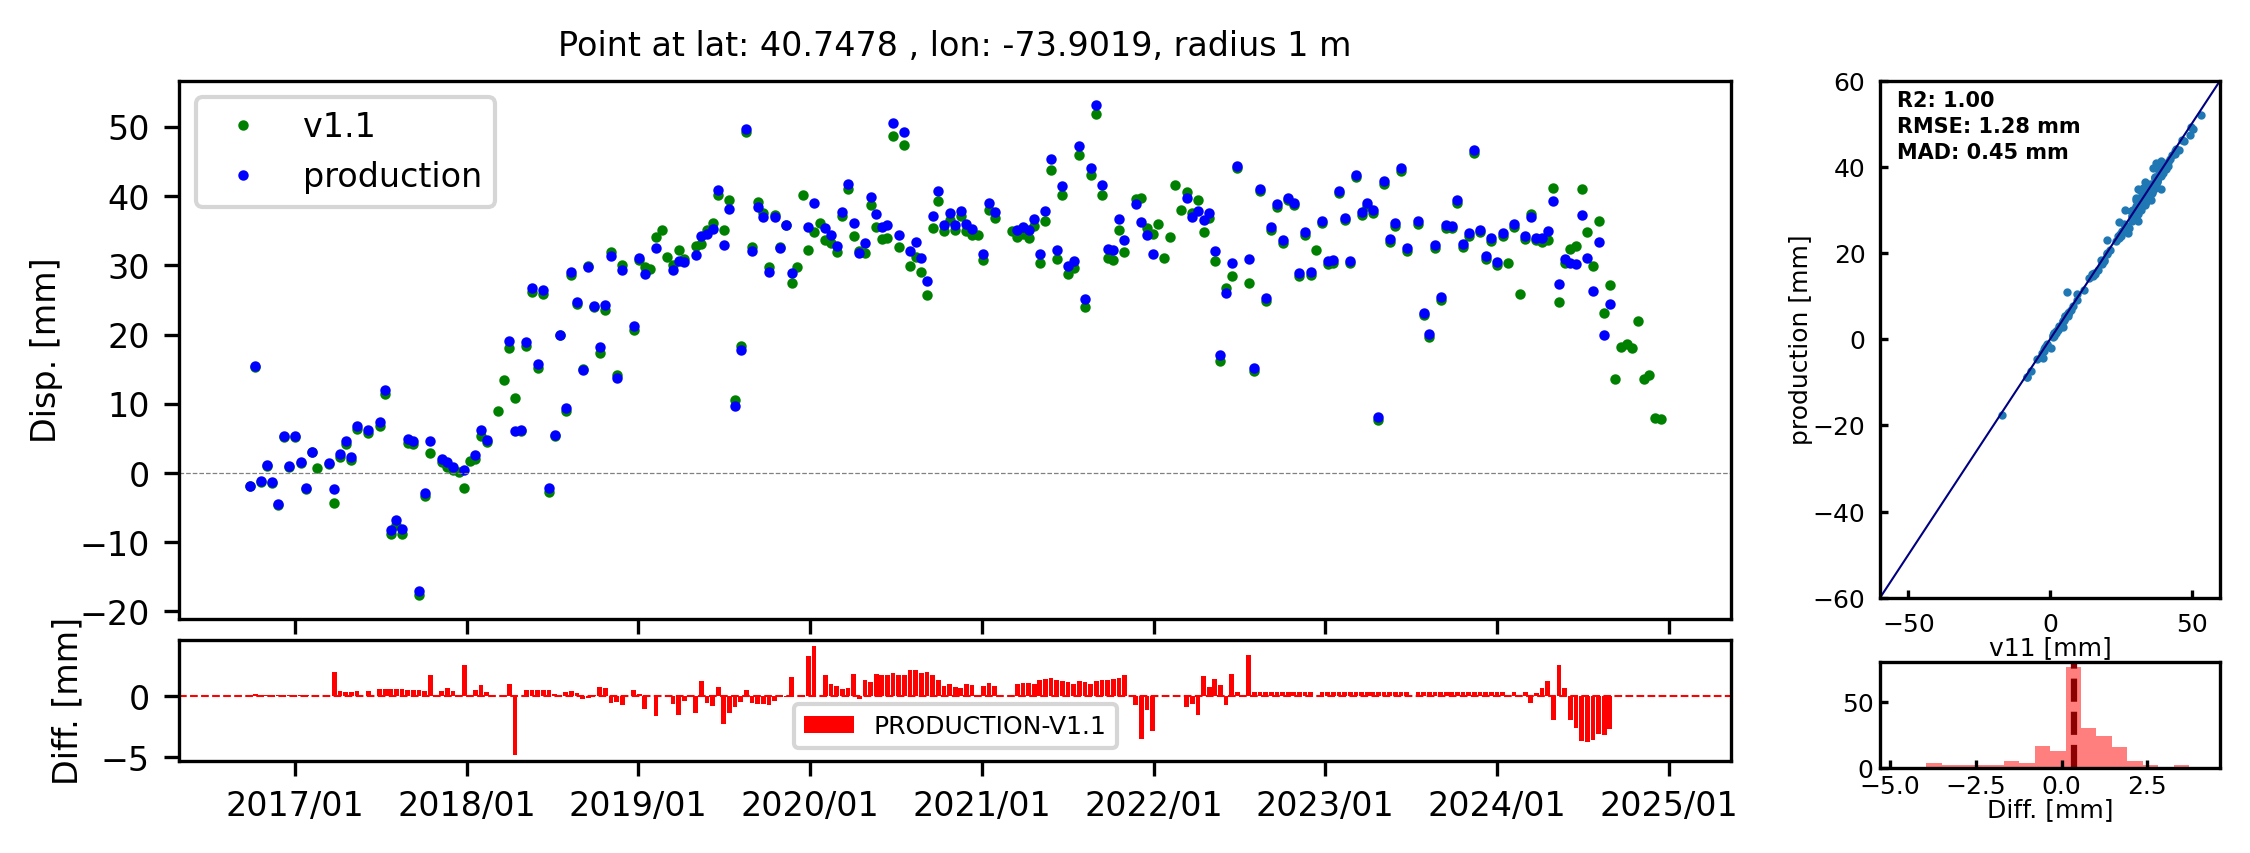

In [178]:
subplots_positions = {'ts': [0.03, 0.22, 0.73, 0.76],
                    'sp': [0.83, 0.25, 0.16, 0.73],
                    'hist': [0.83, 0.01, 0.16, 0.15],
                    'ts_dif': [0.03, 0.02, 0.73, 0.17]}    

point_lalo = ts_points[2]
fontsize = 8
radius = 1

# Get figure layout
cm = 1/2.54 # width X height
fig = plt.figure(figsize=(18*cm, 6*cm), layout="none", dpi=300)
fig, ax = _plot_subplots(fig, subplots_positions) 

ts_data = {}
# Plot timeseries
tv11 = stack_v11.time.values, np.ma.masked_array(v11_ts, mask=~np.bool_(v11_ts_mask)) - reference_ts_v11
tprod = stack_prod.time.values, np.ma.masked_array(prod_ts, mask=~np.bool_(prod_ts_mask)) - reference_ts

ax['ts'].plot(tv11[0],tv11[1]*1e3, '.',
        color='green', label='v1.1', ms=3)
ax['ts'].plot(tprod[0],tprod[1]*1e3, '.',
        color='blue', label='production', ms=3)
unit='mm'
ax['ts'].set_ylabel(f'Disp. [{unit}]', fontsize=fontsize)
ax['ts'].legend(fontsize=fontsize)
ax['ts'].set_title(f'Point at lat: {point_lalo[1]:.4f} , lon: {point_lalo[0]:.4f}, radius {radius:.3g} m',
                fontsize=fontsize)
ax['ts'].tick_params(labelsize=fontsize, labelbottom=False)
ax['ts'].axhline(0, color='gray', lw=0.3, linestyle='--')
#ax['ts'].axvline(stack.time([ref_date])[0], color='gray', linestyle='--', lw=0.3)

# Plot scatter plot
df = plot_scatterplot(ax['sp'], tprod, tv11,
                        'production', 'v11',
                        ms=1, fontsize=fontsize-2,
                        scale=1e3, unit='mm')

# histogram of differences
ax['hist'] = plot_histogram(ax['hist'], df.disp1-df.disp2, scale=1e3, unit='mm', fontsize=fontsize-2)

# Differences
unit='mm'
ax['ts_dif'].bar(df.date1, (df.disp1 - df.disp2)*1e3, color='red', width=1e1,label=f'{labels[0].upper()}-{labels[1].upper()}')
ax['ts_dif'].set_ylabel(f'Diff. [{unit}]', fontsize=fontsize)
ax['ts_dif'].tick_params(labelsize=fontsize)
ax['ts_dif'].set_xticks(ax['ts'].get_xticks())
ax['ts_dif'].set_xlim(ax['ts'].get_xlim())
ax['ts_dif'].axhline(0, color='r', lw=0.5, linestyle='--')
ax['ts_dif'].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y/%m'))
ax['ts_dif'].legend(fontsize=fontsize-2)

In [179]:
%%time
prod_ts = stack_prod.sel(x=ts_point_utm[3][0], y=ts_point_utm[3][1], method='nearest').displacement.values
prod_ts_mask = stack_prod.sel(x=ts_point_utm[3][0], y=ts_point_utm[3][1], method='nearest').recommended_mask.values
reference_ts = stack_prod.sel(y=y, x=x, method='nearest').displacement.values

CPU times: user 21.4 s, sys: 5.25 s, total: 26.6 s
Wall time: 41.7 s


In [180]:
%%time
v11_ts = stack_v11.sel(x=ts_point_utm[3][0], y=ts_point_utm[3][1], method='nearest').displacement.values
v11_ts_mask = stack_v11.sel(x=ts_point_utm[3][0], y=ts_point_utm[3][1], method='nearest').recommended_mask.values
reference_ts_v11 = stack_v11.sel(y=y, x=x, method='nearest').displacement.values

CPU times: user 25.4 s, sys: 6.65 s, total: 32 s
Wall time: 58.1 s


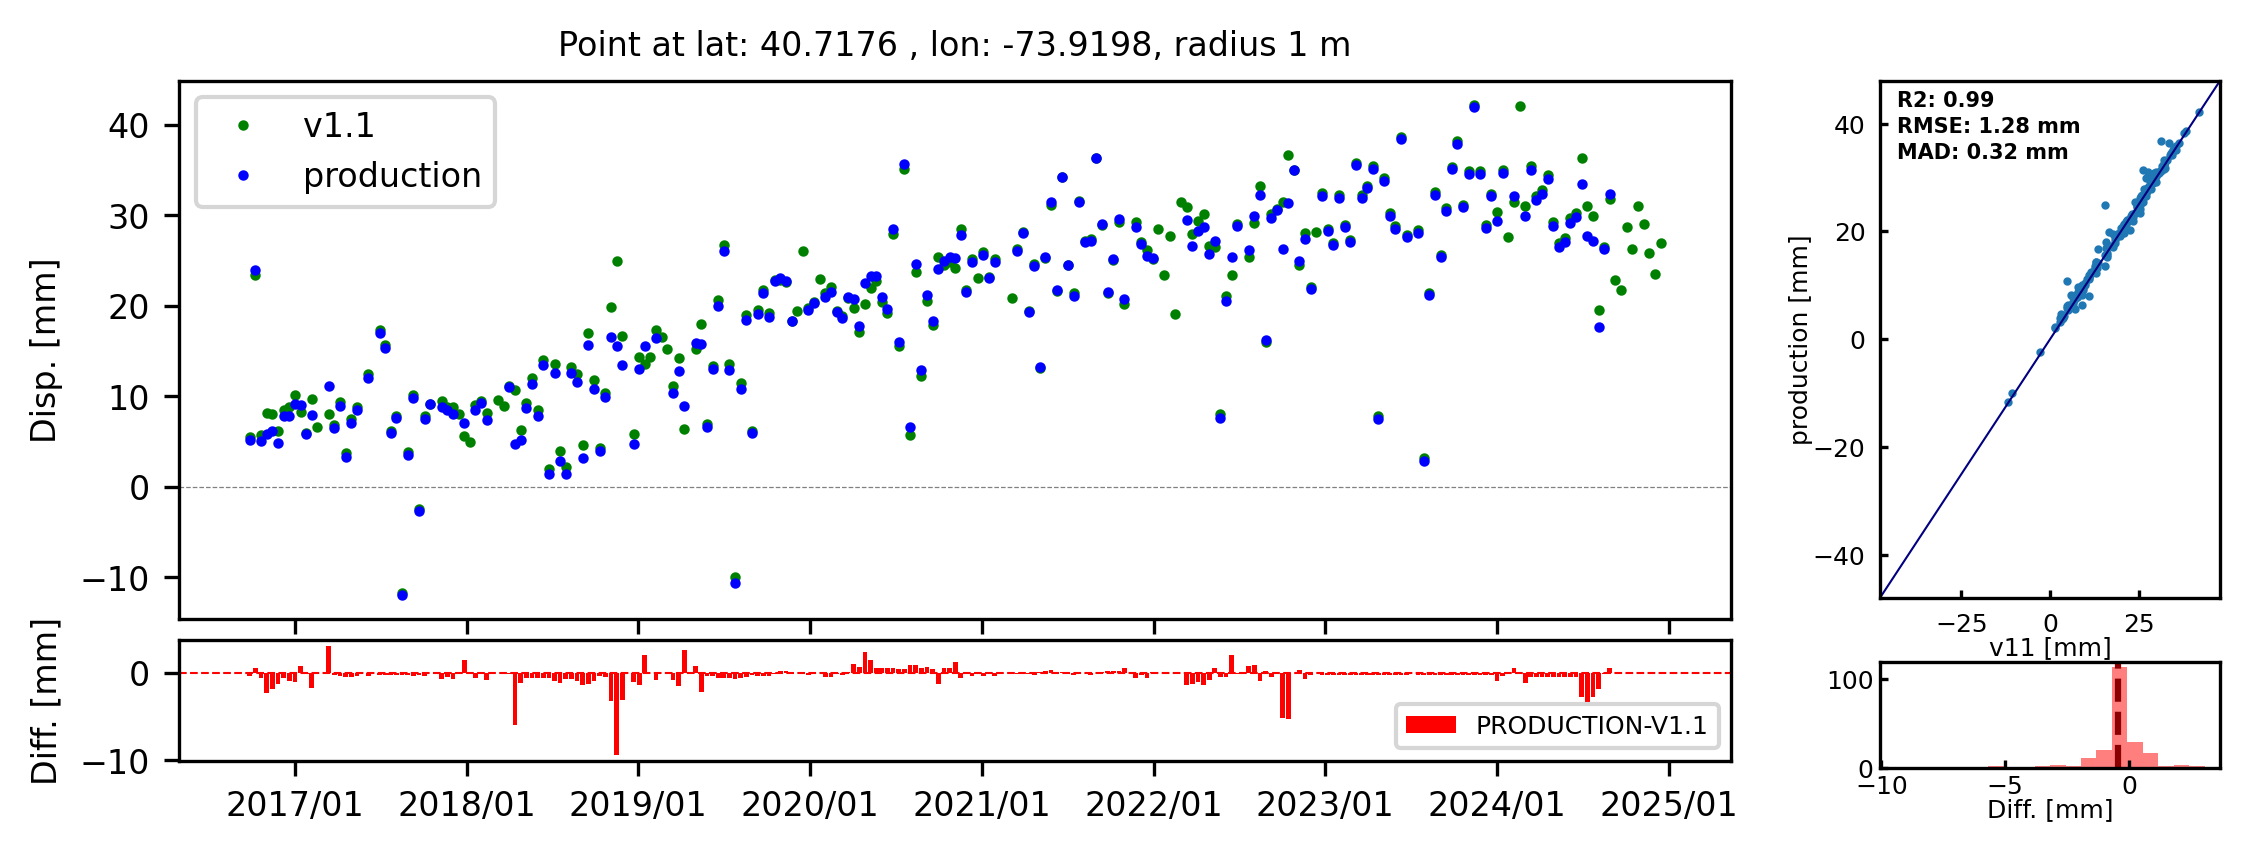

In [181]:
subplots_positions = {'ts': [0.03, 0.22, 0.73, 0.76],
                    'sp': [0.83, 0.25, 0.16, 0.73],
                    'hist': [0.83, 0.01, 0.16, 0.15],
                    'ts_dif': [0.03, 0.02, 0.73, 0.17]}    

point_lalo = ts_points[3]
fontsize = 8
radius = 1

# Get figure layout
cm = 1/2.54 # width X height
fig = plt.figure(figsize=(18*cm, 6*cm), layout="none", dpi=300)
fig, ax = _plot_subplots(fig, subplots_positions) 

ts_data = {}
# Plot timeseries
tv11 = stack_v11.time.values, np.ma.masked_array(v11_ts, mask=~np.bool_(v11_ts_mask)) - reference_ts_v11
tprod = stack_prod.time.values, np.ma.masked_array(prod_ts, mask=~np.bool_(prod_ts_mask)) - reference_ts

ax['ts'].plot(tv11[0],tv11[1]*1e3, '.',
        color='green', label='v1.1', ms=3)
ax['ts'].plot(tprod[0],tprod[1]*1e3, '.',
        color='blue', label='production', ms=3)
unit='mm'
ax['ts'].set_ylabel(f'Disp. [{unit}]', fontsize=fontsize)
ax['ts'].legend(fontsize=fontsize)
ax['ts'].set_title(f'Point at lat: {point_lalo[1]:.4f} , lon: {point_lalo[0]:.4f}, radius {radius:.3g} m',
                fontsize=fontsize)
ax['ts'].tick_params(labelsize=fontsize, labelbottom=False)
ax['ts'].axhline(0, color='gray', lw=0.3, linestyle='--')
#ax['ts'].axvline(stack.time([ref_date])[0], color='gray', linestyle='--', lw=0.3)

# Plot scatter plot
df = plot_scatterplot(ax['sp'], tprod, tv11,
                        'production', 'v11',
                        ms=1, fontsize=fontsize-2,
                        scale=1e3, unit='mm')

# histogram of differences
ax['hist'] = plot_histogram(ax['hist'], df.disp1-df.disp2, scale=1e3, unit='mm', fontsize=fontsize-2)

# Differences
unit='mm'
ax['ts_dif'].bar(df.date1, (df.disp1 - df.disp2)*1e3, color='red', width=1e1,label=f'{labels[0].upper()}-{labels[1].upper()}')
ax['ts_dif'].set_ylabel(f'Diff. [{unit}]', fontsize=fontsize)
ax['ts_dif'].tick_params(labelsize=fontsize)
ax['ts_dif'].set_xticks(ax['ts'].get_xticks())
ax['ts_dif'].set_xlim(ax['ts'].get_xlim())
ax['ts_dif'].axhline(0, color='r', lw=0.5, linestyle='--')
ax['ts_dif'].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y/%m'))
ax['ts_dif'].legend(fontsize=fontsize-2)